📂 Please upload your sales data files (CSV, Excel, JSON):


Saving sales_data_sample.csv to sales_data_sample (1).csv

✅ CSV file detected: sales_data_sample (1).csv
✅ Excel file detected: None
✅ JSON file detected: None

--- CSV Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13 

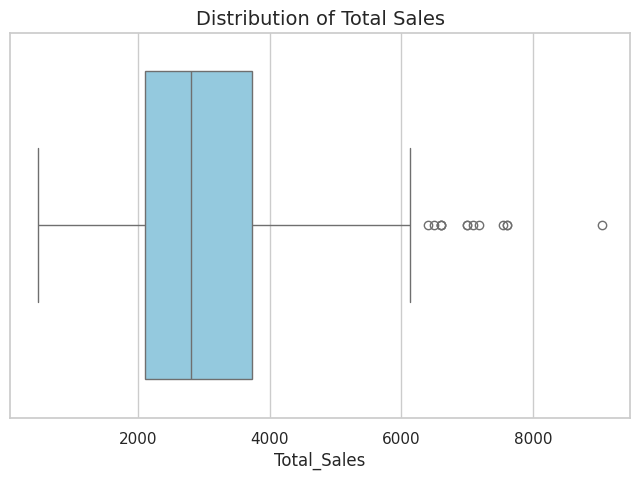

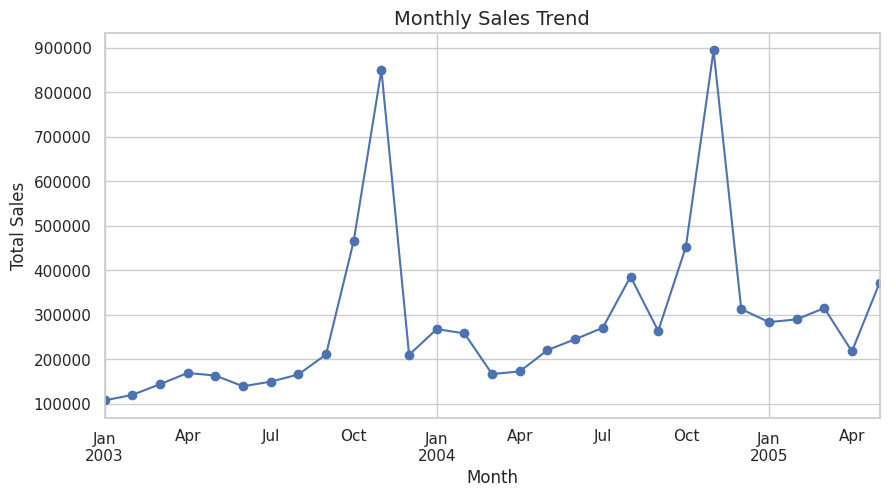

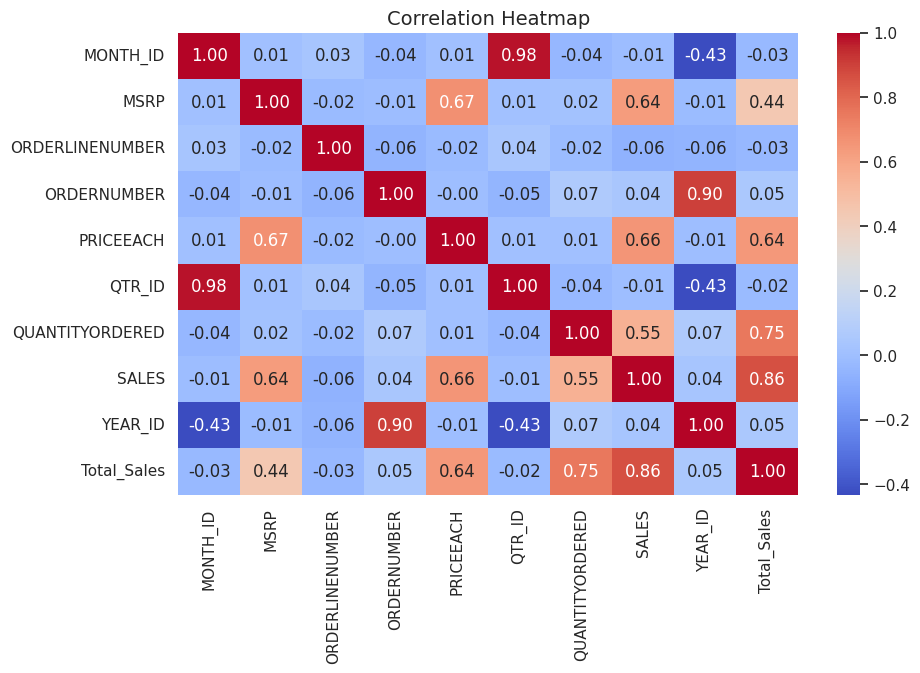


📁 Cleaned data exported as 'Cleaned_Sales_Data.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Analysis complete!


In [9]:
# Install dependency
!pip install openpyxl

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# =======================
# File Upload
# =======================
print("📂 Please upload your sales data files (CSV, Excel, JSON):")
uploaded = files.upload()

# Automatically detect uploaded files by extension
csv_file = None
excel_file = None
json_file = None

for filename in uploaded.keys():
    if filename.endswith('.csv'):
        csv_file = filename
    elif filename.endswith(('.xls', '.xlsx')):
        excel_file = filename
    elif filename.endswith('.json'):
        json_file = filename

print(f"\n✅ CSV file detected: {csv_file}")
print(f"✅ Excel file detected: {excel_file}")
print(f"✅ JSON file detected: {json_file}")

# =======================
# Load Files
# =======================
df_csv = pd.read_csv(csv_file, encoding='latin1', on_bad_lines='skip') if csv_file else pd.DataFrame()
df_excel = pd.read_excel(excel_file) if excel_file else pd.DataFrame()
df_json = pd.read_json(json_file) if json_file else pd.DataFrame()

# =======================
# Explore Data
# =======================
def explore_data(df, name='DataFrame'):
    print(f"\n--- {name} Info ---")
    print(df.info())
    print(f"\n--- {name} Head ---")
    print(df.head())
    print(f"\n--- {name} Missing Values ---")
    print(df.isnull().sum())
    print(f"\n--- {name} Duplicates --- {df.duplicated().sum()}")

if not df_csv.empty: explore_data(df_csv, 'CSV Data')
if not df_excel.empty: explore_data(df_excel, 'Excel Data')
if not df_json.empty: explore_data(df_json, 'JSON Data')

# =======================
# Data Cleaning
# =======================
def clean_data(df):
    if df.empty:
        return df
    df = df.drop_duplicates().copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(0)
        else:
            if not df[col].mode().empty:
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna('Unknown')
    return df

df_csv_clean = clean_data(df_csv)
df_excel_clean = clean_data(df_excel)
df_json_clean = clean_data(df_json)

# =======================
# Align Columns and Merge
# =======================
all_cols = set(df_csv_clean.columns).union(set(df_excel_clean.columns)).union(set(df_json_clean.columns))

def align_columns(df, all_cols):
    for col in all_cols:
        if col not in df.columns:
            df[col] = np.nan
    return df[sorted(all_cols)]

df_csv_aligned = align_columns(df_csv_clean, all_cols)
df_excel_aligned = align_columns(df_excel_clean, all_cols)
df_json_aligned = align_columns(df_json_clean, all_cols)

df_all = pd.concat([df_csv_aligned, df_excel_aligned, df_json_aligned], ignore_index=True)

print("\n--- Combined DataFrame Info ---")
print(df_all.info())

# =======================
# Feature Creation
# =======================
# Flexible detection of price and quantity columns
price_cols = [c for c in df_all.columns if 'price' in c.lower()]
qty_cols = [c for c in df_all.columns if 'qty' in c.lower() or 'quantity' in c.lower()]

if price_cols and qty_cols:
    df_all['Total_Sales'] = df_all[qty_cols[0]].astype(float) * df_all[price_cols[0]].astype(float)
    print("\n✅ 'Total_Sales' column created successfully!")
else:
    print("\n⚠️ Columns for Quantity or Price not found. Skipping 'Total_Sales' calculation.")

# =======================
# Descriptive Statistics
# =======================
print("\n--- Descriptive Statistics ---")
if 'Total_Sales' in df_all.columns:
    total_sales = df_all['Total_Sales'].sum()
    print(f"💰 Total Sales: {total_sales:,.2f}")

if 'OrderID' in df_all.columns and 'Total_Sales' in df_all.columns:
    avg_order_value = df_all.groupby('OrderID')['Total_Sales'].sum().mean()
    print(f"🛒 Average Order Value: {avg_order_value:,.2f}")

if 'Product_Category' in df_all.columns:
    print("\n📦 Product Category Distribution:")
    print(df_all['Product_Category'].value_counts())

# =======================
# Visualizations
# =======================
sns.set(style="whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1️⃣ Total Sales by Product Category
if 'Product_Category' in df_all.columns and 'Total_Sales' in df_all.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_all, x='Product_Category', y='Total_Sales', estimator=sum, ci=None, palette="viridis")
    plt.title('Total Sales by Product Category', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2️⃣ Pie Chart - Product Category Distribution
if 'Product_Category' in df_all.columns:
    plt.figure(figsize=(6,6))
    df_all['Product_Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Product Category Distribution', fontsize=14)
    plt.ylabel('')
    plt.show()

# 3️⃣ Boxplot - Total Sales
if 'Total_Sales' in df_all.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df_all['Total_Sales'], color='skyblue')
    plt.title('Distribution of Total Sales', fontsize=14)
    plt.show()

# 4️⃣ Time Series - Monthly Sales Trend (if date column exists)
date_cols = [c for c in df_all.columns if 'date' in c.lower()]
if date_cols and 'Total_Sales' in df_all.columns:
    df_all[date_cols[0]] = pd.to_datetime(df_all[date_cols[0]], errors='coerce')
    df_all['Month'] = df_all[date_cols[0]].dt.to_period('M')
    plt.figure(figsize=(10,5))
    df_all.groupby('Month')['Total_Sales'].sum().plot(marker='o')
    plt.title('Monthly Sales Trend', fontsize=14)
    plt.ylabel('Total Sales')
    plt.show()

# 5️⃣ Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

# =======================
# Export Cleaned Data
# =======================
df_all.to_excel("Cleaned_Sales_Data.xlsx", index=False)
print("\n📁 Cleaned data exported as 'Cleaned_Sales_Data.xlsx'")
files.download("Cleaned_Sales_Data.xlsx")

print("\n✅ Analysis complete!")
